In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [26]:
df = pd.read_csv('../dataset/cleaned_gc=f.csv')

In [3]:
df = df[['Close']]

# Reset the index
df = df.reset_index(drop=True)

In [4]:
df

,Close
0,1281.000000
1,1291.800049
2,1282.699951
3,1286.800049
4,1283.199951
...,...
1467,2788.500000
1468,2738.300049
1469,2738.600098
1470,2736.100098


# SPLITTING DATA(7-2-1)

In [5]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [6]:
# Training process
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', stepwise=True, suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8831.610, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8833.085, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8833.077, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8830.869, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8835.044, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.247 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [7]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [8]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)


Predicted closing prices for the next 30 days:
[1916.300049 1916.300049 1916.300049 1916.300049 1916.300049 1916.300049
 1916.300049 1916.300049 1916.300049 1916.300049 1916.300049 1916.300049
 1916.300049 1916.300049 1916.300049 1916.300049 1916.300049 1916.300049
 1916.300049 1916.300049 1916.300049 1916.300049 1916.300049 1916.300049
 1916.300049 1916.300049 1916.300049 1916.300049 1916.300049 1916.300049]


In [9]:
# Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 108.26546416965012
Validation RMSE: 562.3637433607706
Testing MAE: 81.8139132619048
Validation MAE: 544.8357558513515
Testing MAPE: 0.04020569532697721
Validation MAPE: 0.21896931404075803


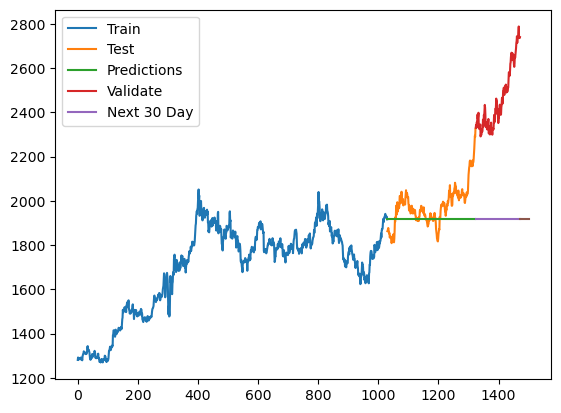

In [10]:
# Plot
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, val_data['Close'])
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next 30 Day'])
plt.show()

In [11]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1030
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4414.435
Date:                Sat, 09 Nov 2024   AIC                           8830.869
Time:                        10:59:11   BIC                           8835.805
Sample:                             0   HQIC                          8832.743
                               - 1030                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       311.7421      7.731     40.326      0.000     296.590     326.894
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):               856.74
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.42
Prob(H) (two-sided):                  0.62   Kurtosis:                         7.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# SPLITTING DATA(6-3-1)

In [12]:
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [13]:
# Training process
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7599.267, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7597.551, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7599.170, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7599.163, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7596.367, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7596.383, Time=0.36 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.047 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [14]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [15]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1761.800049 1761.800049 1761.800049 1761.800049 1761.800049 1761.800049
 1761.800049 1761.800049 1761.800049 1761.800049 1761.800049 1761.800049
 1761.800049 1761.800049 1761.800049 1761.800049 1761.800049 1761.800049
 1761.800049 1761.800049 1761.800049 1761.800049 1761.800049 1761.800049
 1761.800049 1761.800049 1761.800049 1761.800049 1761.800049 1761.800049]


In [16]:
# Calculate accurary for each model
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) 
val_mape = np.mean(val_ape)

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  196.6639957348103
Testing MAE:  165.9389694353742
Testing MAPE:  0.08410587227855025
Validation RMSE:  713.0760677549109
Validation MAE:  699.3357558513515
Validation MAPE:  0.2819392237079173


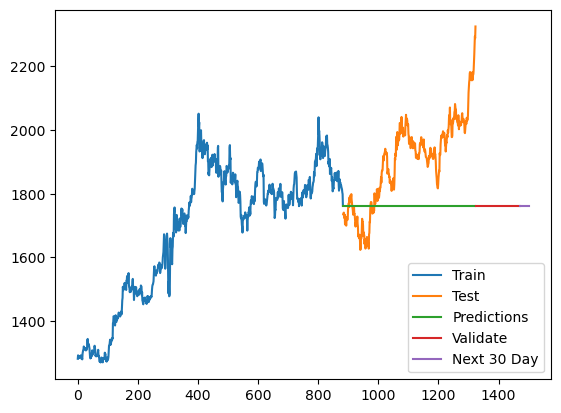

In [17]:
# Plot
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next 30 Day'])
plt.show()

# SPLITTING DATA(5-3-2)

In [18]:
# Split the data into training, testing, and validation sets
train_size = int(0.5 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [19]:
# Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6328.731, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6330.726, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6330.726, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6327.797, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6332.725, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.096 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [20]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [21]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1781.599976 1781.599976 1781.599976 1781.599976 1781.599976 1781.599976
 1781.599976 1781.599976 1781.599976 1781.599976 1781.599976 1781.599976
 1781.599976 1781.599976 1781.599976 1781.599976 1781.599976 1781.599976
 1781.599976 1781.599976 1781.599976 1781.599976 1781.599976 1781.599976
 1781.599976 1781.599976 1781.599976 1781.599976 1781.599976 1781.599976]


In [22]:
# Calculate accuracy for each model
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) 
val_mape = np.mean(val_ape) 

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  123.05790488508975
Testing MAE:  102.98549721315193
Testing MAPE:  0.05449581992027115
Validation RMSE:  523.3635140755011
Validation MAE:  458.5223905898305
Validation MAPE:  0.19467692296709282


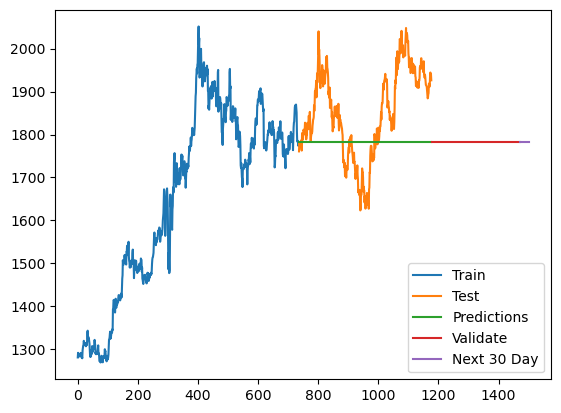

In [23]:
# Plot
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next 30 Day'])
plt.show()

# Comparison

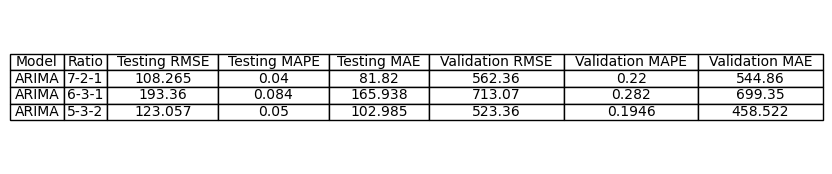

In [24]:
# Define the corrected data for the evaluation table
evaluation_data_corrected = {
    "Model": ["ARIMA", "ARIMA", "ARIMA"],
    "Ratio": ["7-2-1", "6-3-1", "5-3-2"],
    "Testing RMSE": [108.265, 193.36, 123.057],
    "Testing MAPE": [0.04, 0.084, 0.05],
    "Testing MAE": [81.82, 165.938, 102.985],
    "Validation RMSE": [562.36, 713.07, 523.36],
    "Validation MAPE": [0.22, 0.282, 0.1946],
    "Validation MAE": [544.86, 699.35, 458.522]
}

# Create a DataFrame from the corrected data
evaluation_df_corrected = pd.DataFrame(evaluation_data_corrected)

# Plot the corrected table using matplotlib
fig, ax = plt.subplots(figsize=(10, 2))  # Adjust size as needed
ax.axis('off')  # Hide the axis

# Render the corrected table
table = ax.table(cellText=evaluation_df_corrected.values, colLabels=evaluation_df_corrected.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(evaluation_df_corrected.columns))))  # Adjust width of each column

# Save the corrected table as an image
corrected_table_image_path = "C:/HK1/PTTK/new/-STAT3013.-P12_Nhom2-/ComparisonModel/ARIMA/gc=f.png"
plt.savefig(corrected_table_image_path, bbox_inches='tight', dpi=300)
plt.show()